In [1]:
from dataloader import get_train_loader
import matplotlib.pyplot as plt
import torch

In [2]:
loader = get_train_loader(
    ["./dataset/TrainDataset"], 
    batchsize=16,
    train_size=352,
    num_workers=1)

In [3]:
i = 0
for batch in loader:
    print(batch['image'].shape)
    print(batch['inner_image'].shape)
    print(batch['mask'].shape)
    print(batch['slice'].shape)
    print(batch['slice'])
    
    i += 1
    if i == 2:
        break

torch.Size([16, 3, 352, 352])
torch.Size([16, 3, 352, 352])
torch.Size([16, 1, 448, 448])
torch.Size([16, 4])
tensor([[ 16,  85, 368, 437],
        [ 16,  85, 368, 437],
        [ 16,  85, 368, 437],
        [ 16,  85, 368, 437],
        [ 16,  85, 368, 437],
        [ 16,  85, 368, 437],
        [ 16,  85, 368, 437],
        [ 16,  85, 368, 437],
        [ 16,  85, 368, 437],
        [ 16,  85, 368, 437],
        [ 16,  85, 368, 437],
        [ 16,  85, 368, 437],
        [ 16,  85, 368, 437],
        [ 16,  85, 368, 437],
        [ 16,  85, 368, 437],
        [ 16,  85, 368, 437]], dtype=torch.int32)
torch.Size([16, 3, 352, 352])
torch.Size([16, 3, 352, 352])
torch.Size([16, 1, 448, 448])
torch.Size([16, 4])
tensor([[ 71,  54, 423, 406],
        [ 71,  54, 423, 406],
        [ 71,  54, 423, 406],
        [ 71,  54, 423, 406],
        [ 71,  54, 423, 406],
        [ 71,  54, 423, 406],
        [ 71,  54, 423, 406],
        [ 71,  54, 423, 406],
        [ 71,  54, 423, 406],
        [ 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

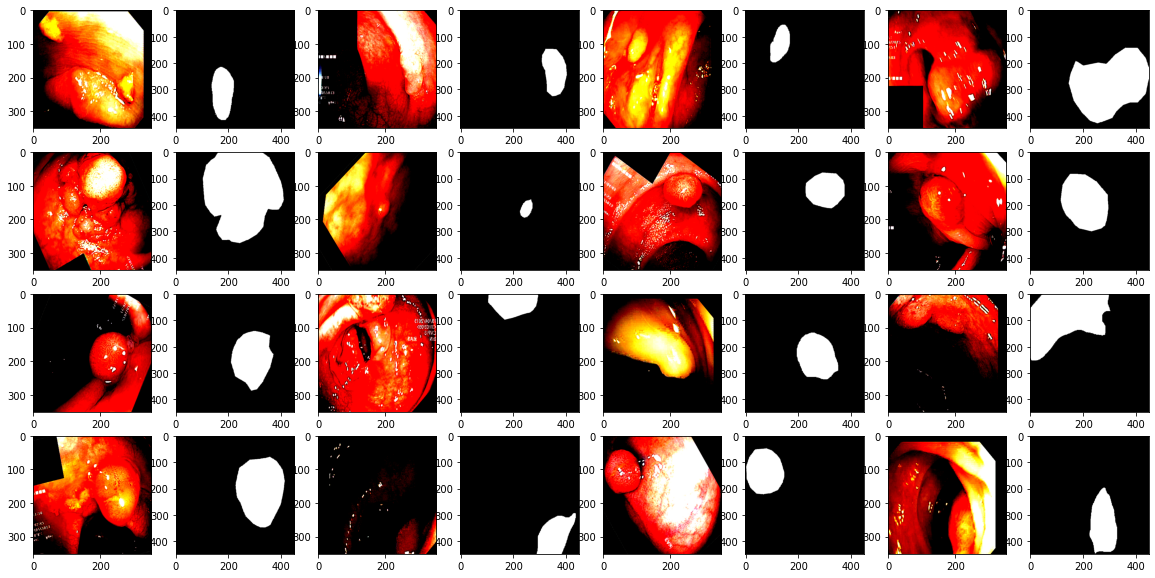

In [6]:
images = batch['image']
masks = batch['mask']

imgs = torch.permute(images, (0, 2, 3, 1))
masks = torch.permute(masks, (0, 2, 3, 1))
plt.figure(figsize=(20, 10))
for i, (img, mask) in enumerate(zip(imgs, masks)):
    plt.subplot(4, 8, 2*i+1)
    plt.imshow(img)
    plt.subplot(4, 8, 2*i+2)
    plt.imshow(mask, cmap='gray')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


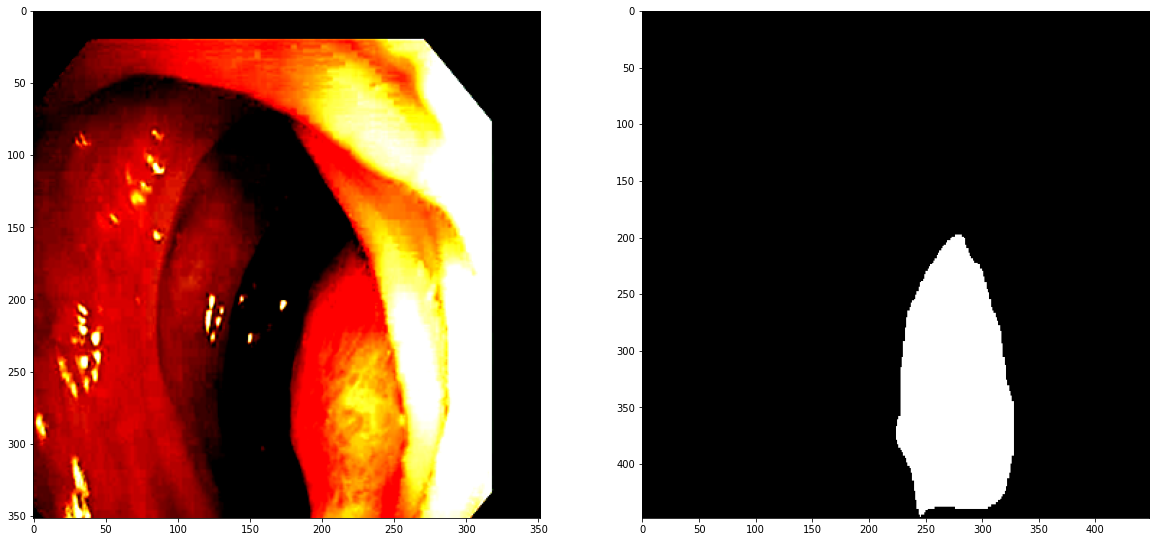

In [7]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.show()

# Design attention head

In [1]:
import torch
from torch import nn
from model import PolypSeg

In [36]:
class AttentionHead(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.up1 = nn.ConvTranspose2d(in_channels=512, out_channels=320, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(in_channels=320, out_channels=128, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up4 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=4)
        self.relu = nn.ReLU(inplace=True)
        self.sigmod = nn.Sigmoid()

    def forward(self, x1, x2, x3, x4):
        x = self.relu(self.up1(x4))
        x = self.relu(self.up2(x))
        x = self.relu(self.up3(x))
        x = self.relu(self.up4(x))
        x = self.sigmod(x)

        return x